<h1>AngleEmbedding Function</h1>

In [1]:
# Importing modules
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers, AngleEmbedding
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from pennylane.ops import RX, RY, RZ
from pennylane.operation import Operation, AnyWires

In [2]:
# Setting parameters

n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/AngleEmbedding" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [3]:
# Loading of the MNIST dataset

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images*np.pi / 255
test_images = test_images*np.pi / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)



In [4]:
"""
We initialize a PennyLane default.qubit device, simulating a system of 4

qubits. The associated qnode represents the quantum circuit consisting of:

1) an embedding layer of local Ry rotations (with angles scaled by a factor of π);
2) a random circuit of n_layers;
3) a final measurement in the computational basis, estimating 4 expectation values.
"""

dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev)
def circuit1(tensor_like):
    # Encoding of 4 classical input values
    AngleEmbedding(features = tensor_like ,wires=range(4), rotation='X', do_queue=True)
    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

@qml.qnode(dev)
def circuit2(tensor_like):
    # Encoding of 4 classical input values
    AngleEmbedding(features = tensor_like ,wires=range(4), rotation='Y', do_queue=True)
    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

@qml.qnode(dev)
def circuit3(tensor_like):
    # Encoding of 4 classical input values
    AngleEmbedding(features = tensor_like ,wires=range(4), rotation='Z', do_queue=True)
    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [5]:
"""
The next function defines the convolution scheme:

1)the image is divided into squares of 2×2 pixels;
2)each square is processed by the quantum circuit;
3)the 4 expectation values are mapped into 4 different channels of a single output pixel.
"""

def quanv(image,circuit):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out



In [6]:
def Process(circuit):
    if PREPROCESS == True:
        q_train_images = []
        print("Quantum pre-processing of train images:")
        for idx, img in enumerate(train_images):
            print("{}/{}        ".format(idx + 1, n_train), end="\r")
            q_train_images.append(quanv(img,circuit))
        q_train_images = np.asarray(q_train_images)

        q_test_images = []
        print("\nQuantum pre-processing of test images:")
        for idx, img in enumerate(test_images):
            print("{}/{}        ".format(idx + 1, n_test), end="\r")
            q_test_images.append(quanv(img,circuit))
        q_test_images = np.asarray(q_test_images)

        # Save pre-processed images
        np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
        np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


    # Load pre-processed images
    q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
    q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

    return q_train_images, q_test_images

In [7]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model



In [8]:
def Train_model(epochs):
    q_model = MyModel()

    q_history = q_model.fit(
        q_train_images,
        train_labels,
        validation_data=(q_test_images, test_labels),
        batch_size=4,
        epochs=epochs,
        verbose=2,
    )

    c_model = MyModel()

    c_history = c_model.fit(
        train_images,
        train_labels,
        validation_data=(test_images, test_labels),
        batch_size=4,
        epochs=epochs,
        verbose=2,
    )
    return q_history, c_history
    

<h1>Rotations </h1>

<h2> X Rotation </h2>

In [9]:
q_train_images, q_test_images = Process(circuit1) # Rotation Process(rotation)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


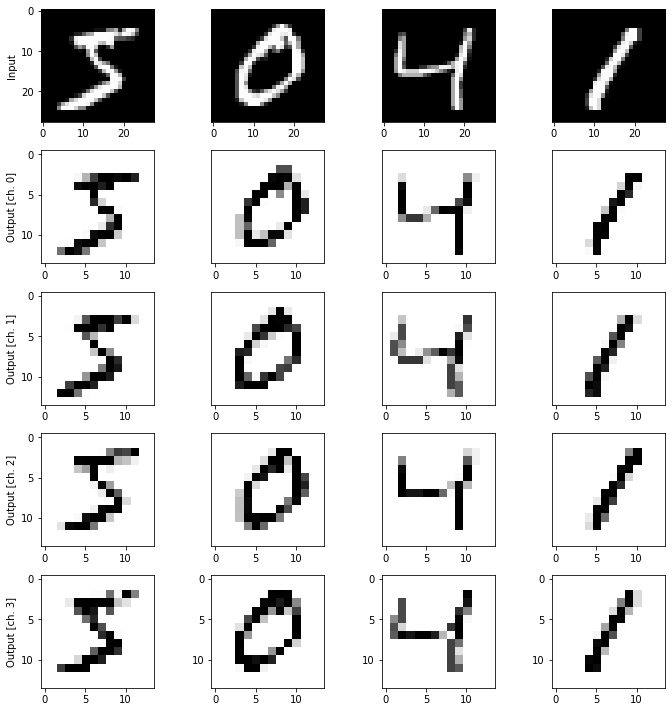

In [10]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [11]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 3.0190 - accuracy: 0.1400 - val_loss: 2.4441 - val_accuracy: 0.2333
Epoch 2/50
13/13 - 0s - loss: 1.9732 - accuracy: 0.3600 - val_loss: 1.9871 - val_accuracy: 0.2667
Epoch 3/50
13/13 - 0s - loss: 1.5429 - accuracy: 0.4600 - val_loss: 1.8192 - val_accuracy: 0.3667
Epoch 4/50
13/13 - 0s - loss: 1.1077 - accuracy: 0.7000 - val_loss: 1.6944 - val_accuracy: 0.4667
Epoch 5/50
13/13 - 0s - loss: 0.9192 - accuracy: 0.7800 - val_loss: 1.5515 - val_accuracy: 0.5333
Epoch 6/50
13/13 - 0s - loss: 0.7544 - accuracy: 0.8400 - val_loss: 1.5061 - val_accuracy: 0.4667
Epoch 7/50
13/13 - 0s - loss: 0.5823 - accuracy: 0.9200 - val_loss: 1.4074 - val_accuracy: 0.5000
Epoch 8/50
13/13 - 0s - loss: 0.4616 - accuracy: 0.9800 - val_loss: 1.3480 - val_accuracy: 0.5667
Epoch 9/50
13/13 - 0s - loss: 0.3888 - accuracy: 0.9800 - val_loss: 1.3037 - val_accuracy: 0.5333
Epoch 10/50
13/13 - 0s - loss: 0.3135 - accuracy: 1.0000 - val_loss: 1.3052 - val_accuracy: 0.6000
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.0205 - accuracy: 1.0000 - val_loss: 1.2489 - val_accuracy: 0.7000
Epoch 35/50
13/13 - 0s - loss: 0.0194 - accuracy: 1.0000 - val_loss: 1.2465 - val_accuracy: 0.7000
Epoch 36/50
13/13 - 0s - loss: 0.0187 - accuracy: 1.0000 - val_loss: 1.2460 - val_accuracy: 0.7000
Epoch 37/50
13/13 - 0s - loss: 0.0179 - accuracy: 1.0000 - val_loss: 1.2439 - val_accuracy: 0.7000
Epoch 38/50
13/13 - 0s - loss: 0.0171 - accuracy: 1.0000 - val_loss: 1.2417 - val_accuracy: 0.7000
Epoch 39/50
13/13 - 0s - loss: 0.0165 - accuracy: 1.0000 - val_loss: 1.2330 - val_accuracy: 0.7000
Epoch 40/50
13/13 - 0s - loss: 0.0158 - accuracy: 1.0000 - val_loss: 1.2334 - val_accuracy: 0.7000
Epoch 41/50
13/13 - 0s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 1.2311 - val_accuracy: 0.7000
Epoch 42/50
13/13 - 0s - loss: 0.0146 - accuracy: 1.0000 - val_loss: 1.2344 - val_accuracy: 0.7000
Epoch 43/50
13/13 - 0s - loss: 0.0141 - accuracy: 1.0000 - val_loss: 1.2349 - val_accuracy: 0.7000
Epoch 44/5

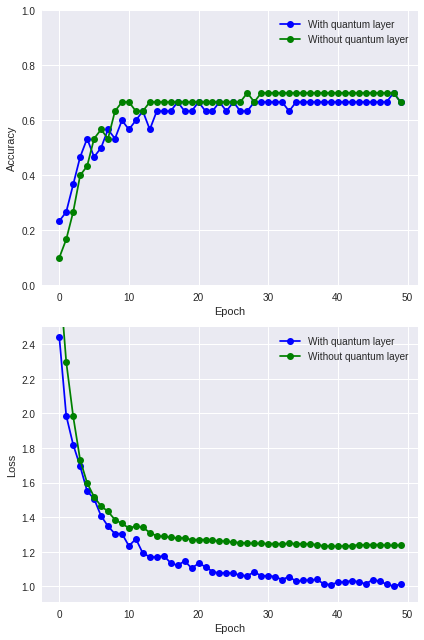

In [12]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


<h2> Y Rotation </h2>

In [13]:
q_train_images, q_test_images = Process(circuit2) # Rotation Process(rotation)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


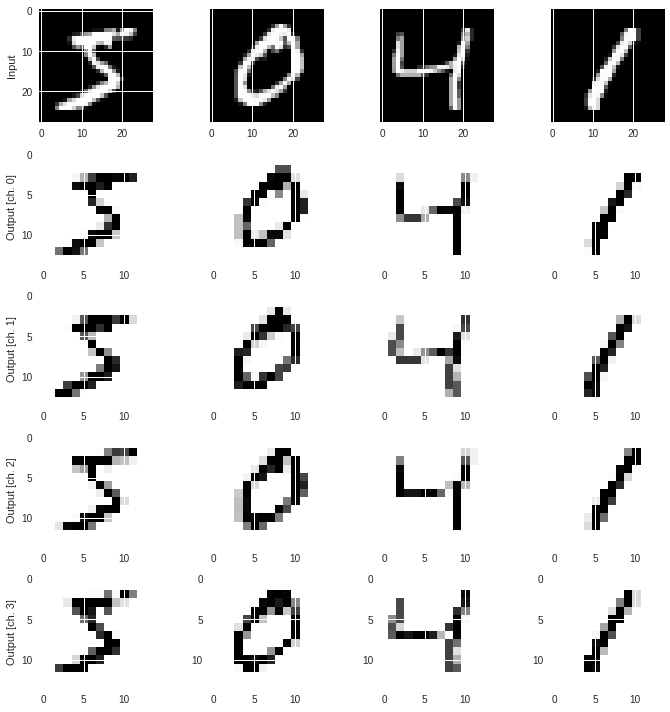

In [14]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [15]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 2.9028 - accuracy: 0.1200 - val_loss: 2.2459 - val_accuracy: 0.2000
Epoch 2/50
13/13 - 0s - loss: 1.9282 - accuracy: 0.3000 - val_loss: 1.9262 - val_accuracy: 0.2333
Epoch 3/50
13/13 - 0s - loss: 1.4796 - accuracy: 0.4800 - val_loss: 1.6963 - val_accuracy: 0.4333
Epoch 4/50
13/13 - 0s - loss: 1.0642 - accuracy: 0.7000 - val_loss: 1.4743 - val_accuracy: 0.5000
Epoch 5/50
13/13 - 0s - loss: 0.8771 - accuracy: 0.8200 - val_loss: 1.3551 - val_accuracy: 0.5333
Epoch 6/50
13/13 - 0s - loss: 0.7088 - accuracy: 0.8800 - val_loss: 1.3126 - val_accuracy: 0.5667
Epoch 7/50
13/13 - 0s - loss: 0.5347 - accuracy: 0.9800 - val_loss: 1.2209 - val_accuracy: 0.6333
Epoch 8/50
13/13 - 0s - loss: 0.4208 - accuracy: 1.0000 - val_loss: 1.1688 - val_accuracy: 0.7000
Epoch 9/50
13/13 - 0s - loss: 0.3592 - accuracy: 0.9800 - val_loss: 1.0957 - val_accuracy: 0.7000
Epoch 10/50
13/13 - 0s - loss: 0.3012 - accuracy: 0.9800 - val_loss: 1.1130 - val_accuracy: 0.6667
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.0199 - accuracy: 1.0000 - val_loss: 1.2323 - val_accuracy: 0.6000
Epoch 35/50
13/13 - 0s - loss: 0.0189 - accuracy: 1.0000 - val_loss: 1.2305 - val_accuracy: 0.6000
Epoch 36/50
13/13 - 0s - loss: 0.0182 - accuracy: 1.0000 - val_loss: 1.2301 - val_accuracy: 0.6000
Epoch 37/50
13/13 - 0s - loss: 0.0174 - accuracy: 1.0000 - val_loss: 1.2276 - val_accuracy: 0.6000
Epoch 38/50
13/13 - 0s - loss: 0.0167 - accuracy: 1.0000 - val_loss: 1.2255 - val_accuracy: 0.6000
Epoch 39/50
13/13 - 0s - loss: 0.0161 - accuracy: 1.0000 - val_loss: 1.2184 - val_accuracy: 0.6000
Epoch 40/50
13/13 - 0s - loss: 0.0155 - accuracy: 1.0000 - val_loss: 1.2199 - val_accuracy: 0.5667
Epoch 41/50
13/13 - 0s - loss: 0.0149 - accuracy: 1.0000 - val_loss: 1.2169 - val_accuracy: 0.5667
Epoch 42/50
13/13 - 0s - loss: 0.0143 - accuracy: 1.0000 - val_loss: 1.2201 - val_accuracy: 0.5667
Epoch 43/50
13/13 - 0s - loss: 0.0138 - accuracy: 1.0000 - val_loss: 1.2211 - val_accuracy: 0.5667
Epoch 44/5

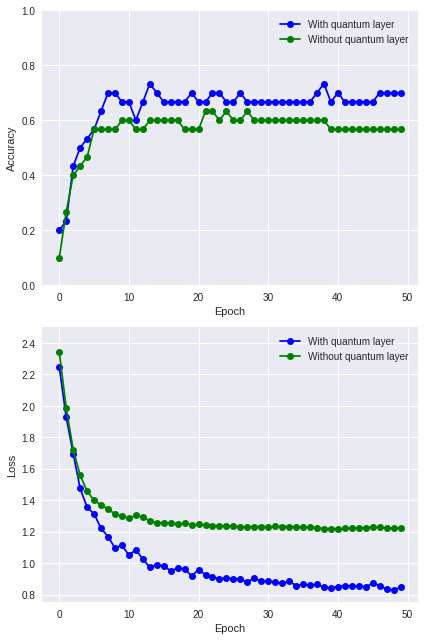

In [16]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


<h1>Z Rotation </h1>

In [17]:
q_train_images, q_test_images = Process(circuit3) # Rotation Process(rotation)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


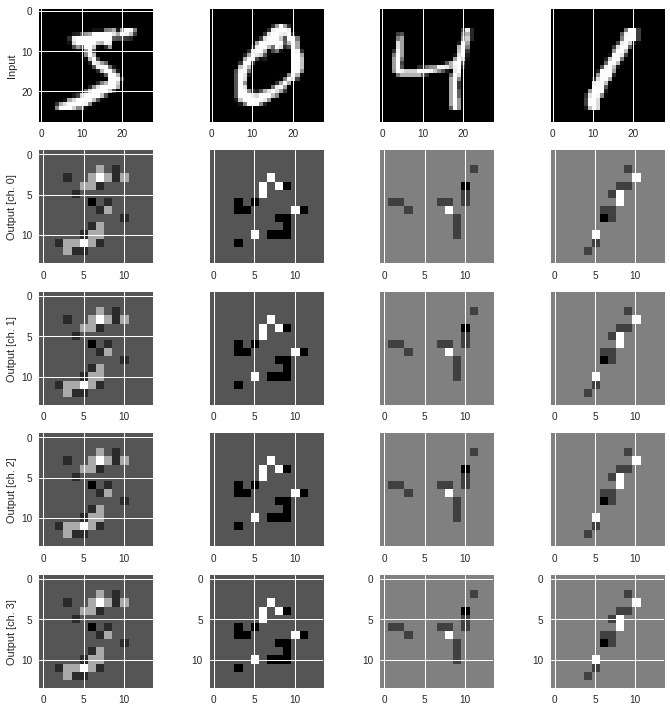

In [18]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [19]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 1s - loss: 3.1742 - accuracy: 0.1000 - val_loss: 2.4678 - val_accuracy: 0.1000
Epoch 2/50
13/13 - 0s - loss: 2.5940 - accuracy: 0.1000 - val_loss: 2.3908 - val_accuracy: 0.1667
Epoch 3/50
13/13 - 0s - loss: 2.5996 - accuracy: 0.1400 - val_loss: 2.5034 - val_accuracy: 0.1333
Epoch 4/50
13/13 - 0s - loss: 2.3946 - accuracy: 0.1400 - val_loss: 2.2733 - val_accuracy: 0.0333
Epoch 5/50
13/13 - 0s - loss: 2.5232 - accuracy: 0.0600 - val_loss: 2.3707 - val_accuracy: 0.1333
Epoch 6/50
13/13 - 0s - loss: 2.6161 - accuracy: 0.1200 - val_loss: 2.4508 - val_accuracy: 0.0333
Epoch 7/50
13/13 - 0s - loss: 2.4738 - accuracy: 0.0800 - val_loss: 2.2569 - val_accuracy: 0.1667
Epoch 8/50
13/13 - 0s - loss: 2.5892 - accuracy: 0.1000 - val_loss: 2.4088 - val_accuracy: 0.0333
Epoch 9/50
13/13 - 0s - loss: 2.4893 - accuracy: 0.1200 - val_loss: 2.2808 - val_accuracy: 0.1333
Epoch 10/50
13/13 - 0s - loss: 2.3765 - accuracy: 0.1200 - val_loss: 2.4427 - val_accuracy: 0.0333
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.0216 - accuracy: 1.0000 - val_loss: 1.2719 - val_accuracy: 0.6667
Epoch 35/50
13/13 - 0s - loss: 0.0205 - accuracy: 1.0000 - val_loss: 1.2722 - val_accuracy: 0.6667
Epoch 36/50
13/13 - 0s - loss: 0.0197 - accuracy: 1.0000 - val_loss: 1.2753 - val_accuracy: 0.6667
Epoch 37/50
13/13 - 0s - loss: 0.0188 - accuracy: 1.0000 - val_loss: 1.2742 - val_accuracy: 0.6667
Epoch 38/50
13/13 - 0s - loss: 0.0181 - accuracy: 1.0000 - val_loss: 1.2765 - val_accuracy: 0.6667
Epoch 39/50
13/13 - 0s - loss: 0.0174 - accuracy: 1.0000 - val_loss: 1.2708 - val_accuracy: 0.6667
Epoch 40/50
13/13 - 0s - loss: 0.0167 - accuracy: 1.0000 - val_loss: 1.2725 - val_accuracy: 0.6667
Epoch 41/50
13/13 - 0s - loss: 0.0160 - accuracy: 1.0000 - val_loss: 1.2728 - val_accuracy: 0.6667
Epoch 42/50
13/13 - 0s - loss: 0.0154 - accuracy: 1.0000 - val_loss: 1.2755 - val_accuracy: 0.6667
Epoch 43/50
13/13 - 0s - loss: 0.0148 - accuracy: 1.0000 - val_loss: 1.2783 - val_accuracy: 0.6667
Epoch 44/5

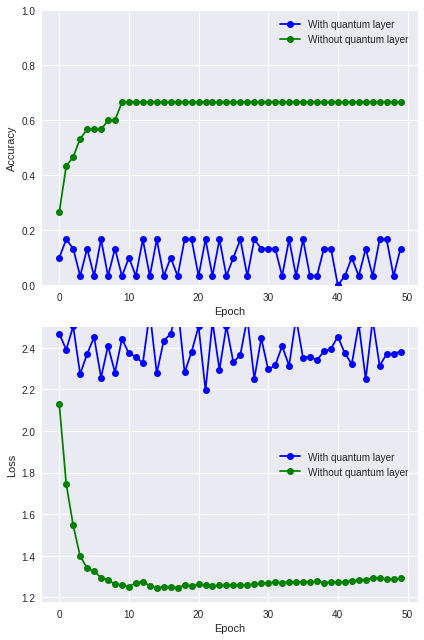

In [20]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


<h1> Epochs Changes </h1>

<p> We found out the best rotation circuits are X and Y. Thus, we will use for epochs changes</p>

<h2> Epoch = 100 (X Rotations)</h2>

In [21]:
q_train_images, q_test_images = Process(circuit1) # Rotation Process(rotation)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


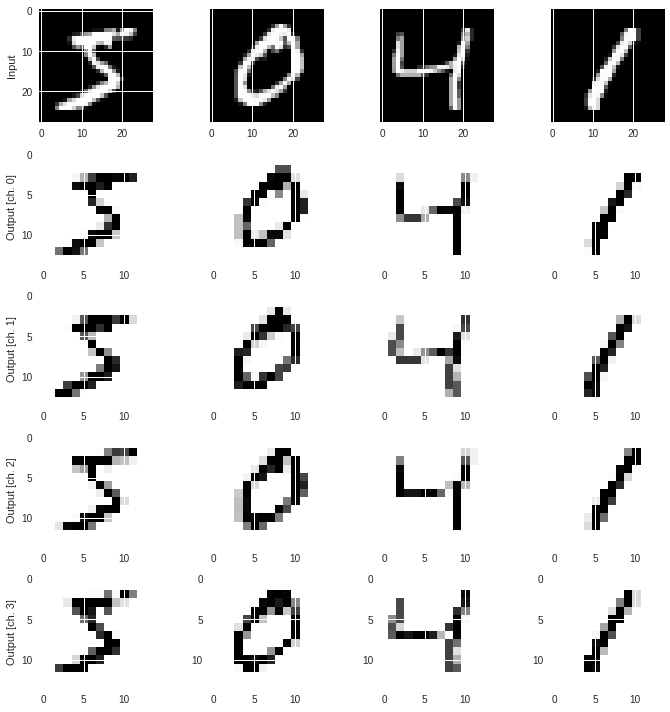

In [22]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [23]:
q_history, c_history = Train_model(100)

Epoch 1/100
13/13 - 0s - loss: 3.0723 - accuracy: 0.1400 - val_loss: 2.3332 - val_accuracy: 0.1000
Epoch 2/100
13/13 - 0s - loss: 2.0319 - accuracy: 0.3000 - val_loss: 2.0117 - val_accuracy: 0.2000
Epoch 3/100
13/13 - 0s - loss: 1.5389 - accuracy: 0.5200 - val_loss: 1.7599 - val_accuracy: 0.4333
Epoch 4/100
13/13 - 0s - loss: 1.0988 - accuracy: 0.6400 - val_loss: 1.5377 - val_accuracy: 0.5333
Epoch 5/100
13/13 - 0s - loss: 0.8928 - accuracy: 0.8000 - val_loss: 1.4035 - val_accuracy: 0.5667
Epoch 6/100
13/13 - 0s - loss: 0.7460 - accuracy: 0.8600 - val_loss: 1.3382 - val_accuracy: 0.5000
Epoch 7/100
13/13 - 0s - loss: 0.5572 - accuracy: 0.9200 - val_loss: 1.2614 - val_accuracy: 0.5667
Epoch 8/100
13/13 - 0s - loss: 0.4300 - accuracy: 1.0000 - val_loss: 1.1473 - val_accuracy: 0.6667
Epoch 9/100
13/13 - 0s - loss: 0.3732 - accuracy: 0.9800 - val_loss: 1.1083 - val_accuracy: 0.7333
Epoch 10/100
13/13 - 0s - loss: 0.3015 - accuracy: 1.0000 - val_loss: 1.1186 - val_accuracy: 0.7333
Epoch 11/

13/13 - 0s - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.7816 - val_accuracy: 0.7667
Epoch 84/100
13/13 - 0s - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.7753 - val_accuracy: 0.7667
Epoch 85/100
13/13 - 0s - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.7813 - val_accuracy: 0.7667
Epoch 86/100
13/13 - 0s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.7880 - val_accuracy: 0.7667
Epoch 87/100
13/13 - 0s - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.7829 - val_accuracy: 0.7333
Epoch 88/100
13/13 - 0s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.7818 - val_accuracy: 0.7333
Epoch 89/100
13/13 - 0s - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.7809 - val_accuracy: 0.7667
Epoch 90/100
13/13 - 0s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.7804 - val_accuracy: 0.7667
Epoch 91/100
13/13 - 0s - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.7799 - val_accuracy: 0.7667
Epoch 92/100
13/13 - 0s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.7834 - val_accuracy: 0.7333
Epoch 93/100


Epoch 66/100
13/13 - 0s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 1.0707 - val_accuracy: 0.8000
Epoch 67/100
13/13 - 0s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.0716 - val_accuracy: 0.8000
Epoch 68/100
13/13 - 0s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 1.0719 - val_accuracy: 0.8000
Epoch 69/100
13/13 - 0s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 1.0740 - val_accuracy: 0.8000
Epoch 70/100
13/13 - 0s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 1.0743 - val_accuracy: 0.8000
Epoch 71/100
13/13 - 0s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 1.0739 - val_accuracy: 0.8000
Epoch 72/100
13/13 - 0s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.0767 - val_accuracy: 0.8000
Epoch 73/100
13/13 - 0s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.0750 - val_accuracy: 0.8000
Epoch 74/100
13/13 - 0s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.0732 - val_accuracy: 0.8000
Epoch 75/100
13/13 - 0s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.0731 - val_accuracy: 0.8000


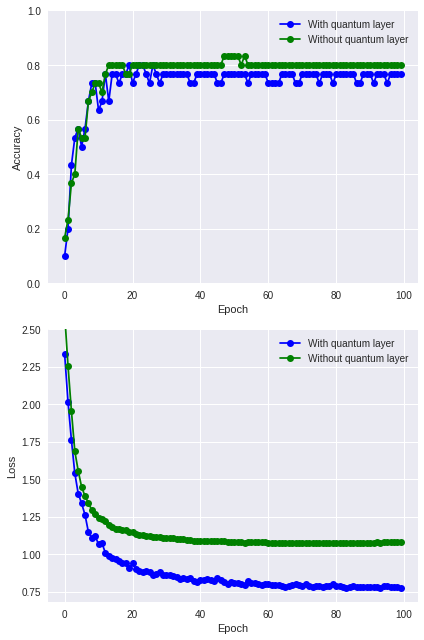

In [24]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


<h2>Epoch = 75 (X Rotations)</h2>

In [25]:
q_train_images, q_test_images = Process(circuit1) # Rotation Process(rotation)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


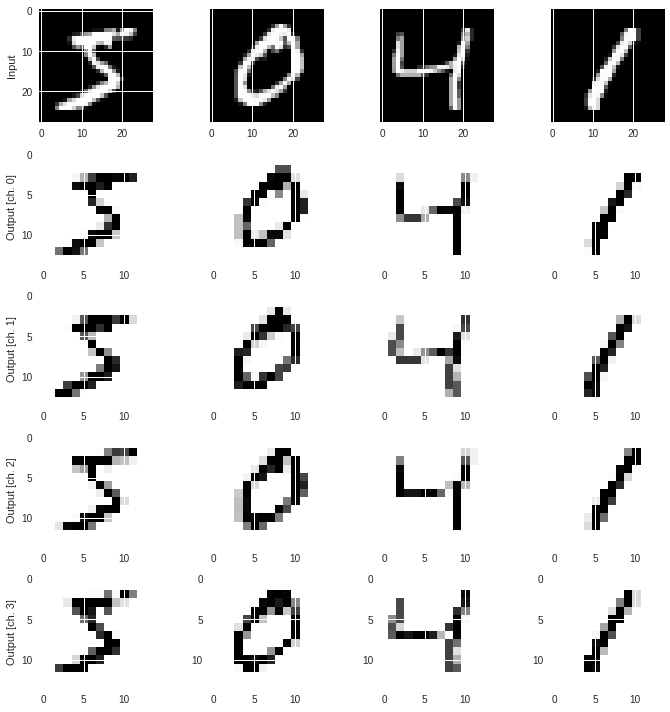

In [26]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [27]:
q_history, c_history = Train_model(75)

Epoch 1/75
13/13 - 0s - loss: 3.2051 - accuracy: 0.0800 - val_loss: 2.6843 - val_accuracy: 0.1333
Epoch 2/75
13/13 - 0s - loss: 2.1360 - accuracy: 0.2000 - val_loss: 2.2009 - val_accuracy: 0.2000
Epoch 3/75
13/13 - 0s - loss: 1.5839 - accuracy: 0.5000 - val_loss: 2.1034 - val_accuracy: 0.2333
Epoch 4/75
13/13 - 0s - loss: 1.1522 - accuracy: 0.6400 - val_loss: 1.7205 - val_accuracy: 0.5000
Epoch 5/75
13/13 - 0s - loss: 0.9231 - accuracy: 0.8400 - val_loss: 1.6315 - val_accuracy: 0.5000
Epoch 6/75
13/13 - 0s - loss: 0.7489 - accuracy: 0.8600 - val_loss: 1.5695 - val_accuracy: 0.5667
Epoch 7/75
13/13 - 0s - loss: 0.5761 - accuracy: 0.9400 - val_loss: 1.4494 - val_accuracy: 0.5333
Epoch 8/75
13/13 - 0s - loss: 0.4569 - accuracy: 1.0000 - val_loss: 1.3543 - val_accuracy: 0.6000
Epoch 9/75
13/13 - 0s - loss: 0.3862 - accuracy: 0.9800 - val_loss: 1.2794 - val_accuracy: 0.6000
Epoch 10/75
13/13 - 0s - loss: 0.3077 - accuracy: 1.0000 - val_loss: 1.3242 - val_accuracy: 0.6333
Epoch 11/75
13/13 -

Epoch 9/75
13/13 - 0s - loss: 0.1804 - accuracy: 1.0000 - val_loss: 1.3585 - val_accuracy: 0.6333
Epoch 10/75
13/13 - 0s - loss: 0.1471 - accuracy: 1.0000 - val_loss: 1.3529 - val_accuracy: 0.6333
Epoch 11/75
13/13 - 0s - loss: 0.1266 - accuracy: 1.0000 - val_loss: 1.3343 - val_accuracy: 0.5667
Epoch 12/75
13/13 - 0s - loss: 0.1097 - accuracy: 1.0000 - val_loss: 1.3613 - val_accuracy: 0.5667
Epoch 13/75
13/13 - 0s - loss: 0.0940 - accuracy: 1.0000 - val_loss: 1.3592 - val_accuracy: 0.6000
Epoch 14/75
13/13 - 0s - loss: 0.0816 - accuracy: 1.0000 - val_loss: 1.3231 - val_accuracy: 0.6333
Epoch 15/75
13/13 - 0s - loss: 0.0724 - accuracy: 1.0000 - val_loss: 1.3117 - val_accuracy: 0.6333
Epoch 16/75
13/13 - 0s - loss: 0.0648 - accuracy: 1.0000 - val_loss: 1.3181 - val_accuracy: 0.6333
Epoch 17/75
13/13 - 0s - loss: 0.0592 - accuracy: 1.0000 - val_loss: 1.3173 - val_accuracy: 0.6333
Epoch 18/75
13/13 - 0s - loss: 0.0539 - accuracy: 1.0000 - val_loss: 1.3067 - val_accuracy: 0.6333
Epoch 19/75

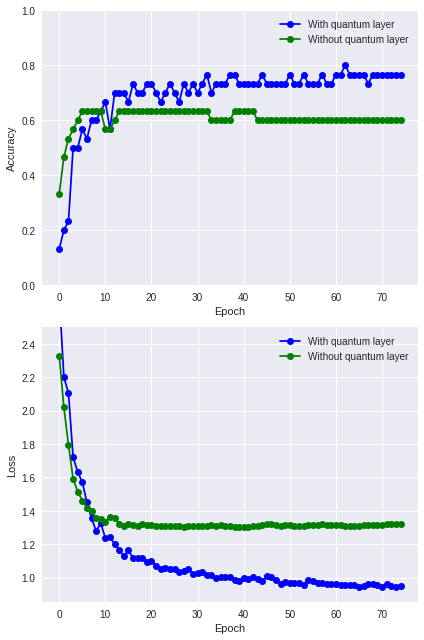

In [28]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


<h2>Epoch = 25 (X Rotations)</h2>

In [29]:
q_train_images, q_test_images = Process(circuit1) # Rotation Process(rotation)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


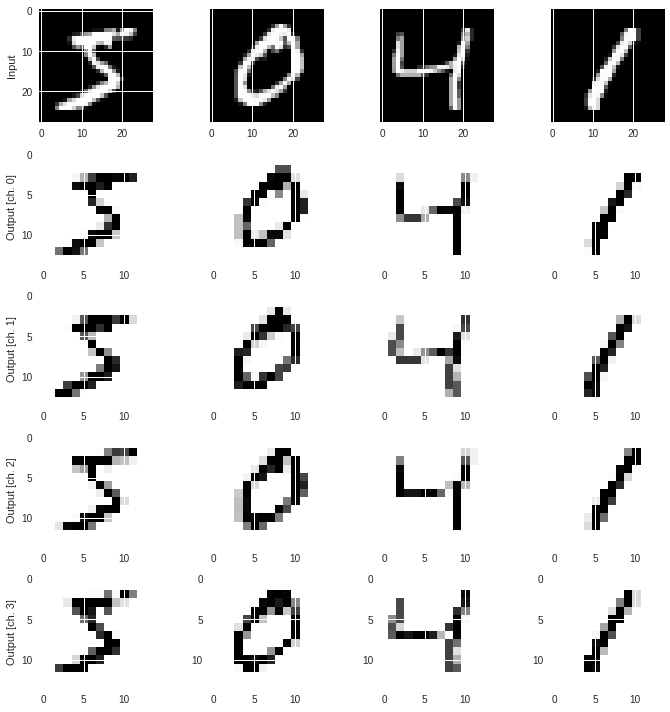

In [30]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [31]:
q_history, c_history = Train_model(25)

Epoch 1/25
13/13 - 0s - loss: 2.9287 - accuracy: 0.0800 - val_loss: 2.1832 - val_accuracy: 0.1000
Epoch 2/25
13/13 - 0s - loss: 2.0352 - accuracy: 0.3000 - val_loss: 1.9912 - val_accuracy: 0.3333
Epoch 3/25
13/13 - 0s - loss: 1.5319 - accuracy: 0.5400 - val_loss: 1.8683 - val_accuracy: 0.3333
Epoch 4/25
13/13 - 0s - loss: 1.1025 - accuracy: 0.7600 - val_loss: 1.5298 - val_accuracy: 0.4667
Epoch 5/25
13/13 - 0s - loss: 0.9303 - accuracy: 0.8200 - val_loss: 1.4483 - val_accuracy: 0.4667
Epoch 6/25
13/13 - 0s - loss: 0.7614 - accuracy: 0.8600 - val_loss: 1.4297 - val_accuracy: 0.4667
Epoch 7/25
13/13 - 0s - loss: 0.5844 - accuracy: 0.9400 - val_loss: 1.3232 - val_accuracy: 0.5333
Epoch 8/25
13/13 - 0s - loss: 0.4611 - accuracy: 0.9600 - val_loss: 1.2183 - val_accuracy: 0.6333
Epoch 9/25
13/13 - 0s - loss: 0.3950 - accuracy: 0.9600 - val_loss: 1.1807 - val_accuracy: 0.6000
Epoch 10/25
13/13 - 0s - loss: 0.3216 - accuracy: 1.0000 - val_loss: 1.1945 - val_accuracy: 0.6000
Epoch 11/25
13/13 -

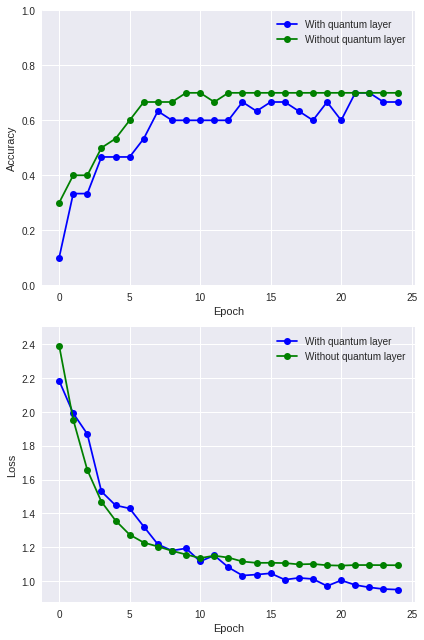

In [32]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
